In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class consts:
    pi = 3.141592
    c = 3e8
    e = 1.6e-19

class setup:
    dummy = 0

### Первичные экспериментальные данные

### Аппаратная функция монохроматора

In [3]:
calibration_data = mipt.read_excel('data/5.1.1-stripped.xlsx', usecols=('A', 'B'), header=(0, 1))
calibration_data = calibration_data['Calibration']
calibration_data

,lambda,N
0,7032.41,2992.0
1,6929.47,2966.0
2,6717.04,2895.0
3,6678.28,2882.0
4,6598.95,2855.0
5,6532.88,2832.0
6,6506.53,2824.0
7,6402.24,2785.0
8,6382.99,2778.0
9,6334.42,2759.0


C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


array(5400.56)

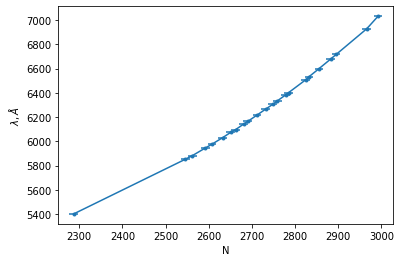

In [138]:
def interp(x, y):
    return sp.interpolate.interp1d(x, y, kind='linear')

_, _, N2wavelen = mipt.plot(calibration_data['N'], calibration_data['lambda'], func=interp, xerr=10)

plt.xlabel(r'N')
plt.ylabel(r'$\lambda, \AA$')
plt.savefig('gen/calibration.pdf')

N2wavelen(2287)

### Зависимость $I(V)$

2759


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,-0.071818,0.03876,0.228051,0.017265,0.025562,0.659478,0.0342,0.275414,0.007167


N=2759, V_0 = (-0.418 +- 0.024) В
2882


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,0.027273,0.039256,0.246763,0.018926,0.026887,0.684911,0.038029,0.228084,0.007606


N=2882, V_0 = (-0.333 +- 0.022) В
2824


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,-0.036364,0.032314,0.231177,0.016103,0.022565,0.698316,0.03444,0.25657,0.006316


N=2824, V_0 = (-0.367 +- 0.020) В
2992


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,0.158333,0.025347,0.277676,0.010396,0.016191,0.638782,0.02297,0.176535,0.005158


N=2992, V_0 = (-0.276 +- 0.013) В


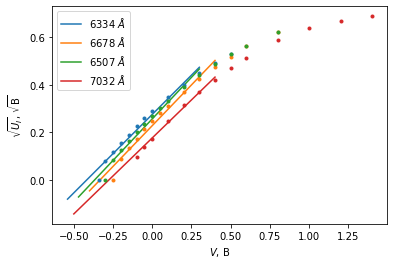

In [139]:

output = []
def process(cols, begin, end, begin_interp, end_interp, x_min):
    data = mipt.read_excel('data/5.1.1-stripped.xlsx', usecols=(cols), header=(0, 1)).dropna()
    data = data.iloc[::-1]
    # Extract N from header
    m = re.compile(r"N=(\d+)")
    result = m.match(data.columns[0][0])
    assert result != None, "Wrong header syntax"
    N = int(result.group(1))
    print(N)
    # Remove top header
    data = data[f'N={N}']
    U_v = list(data['U_close'][begin:end])
    U_i = list(data['U_i'    ][begin:end])

    # Evaluate wavelen according to calibration

    wavelen = float(N2wavelen(N))
    
    U_v_clean, U_i_clean, equ = mipt.plot(U_v, np.sqrt(U_i), begin=begin_interp, end=end_interp, x_min=x_min,
                                          label="{:.0f} $\AA$".format(wavelen))
    
    res = mipt.mnk(U_v_clean, U_i_clean).data
    display(res)
    V_0 = - float(res['b'] / res['a'])
    V_0_err = abs(V_0) * float(* np.sqrt((res['db']/res['b'])**2 + (res['da']/res['a'])**2))

    output.append([wavelen, V_0, V_0_err])

    print("N={}, V_0 = ({:0.3f} +- {:0.3f}) В".format(N, V_0, V_0_err))


process(('P', 'Q'), 0, 13, 0, 10, -0.54)
process(('J', 'K'), 0, 14, 0, 10, -0.4)
process(('M', 'N'), 0, 15, 0, 10, -0.47)
process(('G', 'H'), 1, 14, 1, 6, -0.5)

plt.xlabel(r'$V$, В')
plt.ylabel(r'$\sqrt{U_I}$, $\sqrt{\mathrm{В}}$')
plt.legend()
#plt.grid(True)
plt.savefig('gen/iv.pdf')


In [157]:


process(('D', 'E'), 1, 14, 0, 10, -0.8)
process(('Y', 'Z'), 0, 15, 0, 12, -0.63)
process(('V', 'W'), 0, 15, 0, 13, -0.63)
process(('S', 'T'), 0, 15, 0, 10, -0.63)

plt.xlabel(r'$V$, В')
plt.ylabel(r'$\sqrt{U_I}$, $\sqrt{\mathrm{В}}$')
plt.legend()
#plt.grid(True)
plt.savefig('gen/iv2.pdf')

ValueError: A value in x_new is below the interpolation range.

In [141]:
output

[[6334.42, -0.41762373989154067, 0.024231710945449854],
 [6678.28, -0.3330122704054367, 0.021568318705126644],
 [6506.53, -0.3674127289936253, 0.020252299779044705],
 [7032.41, -0.27636240492228287, 0.012804298367952485],
 [5400.56, -0.7859712295489698, 0.03858736884158641],
 [5944.83, -0.535568242119411, 0.028529497783429843],
 [6074.34, -0.4950199336218488, 0.027394881249857332],
 [6217.28, -0.4467654886281772, 0.02323049250301083]]

### V_0(omega)

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,3.021456e+15,5.279516e+28,0.457217,0.021691,3.352365e+13,6.349759e-16,3.570413e-17,-1.461335,0.10819


W ~ 1.46 эВ, hbar = (1.02 +- 0.06)e-34 Дж*с


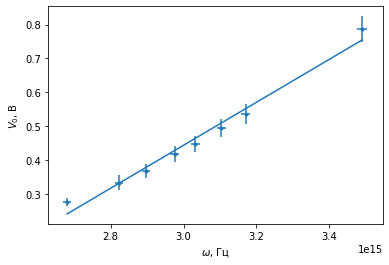

In [144]:
# Unzip output
wavelen, V_0, V_0_err = [np.array(i) for i in zip(*output)]

omega = (2 * np.pi * consts.c) / (wavelen / 1.0e10)

wavelen_clean, V_0_clean, _ = mipt.plot(omega, abs(V_0), yerr=V_0_err, xerr=10/2500*omega)

plt.xlabel(r"$\omega$, Гц")
plt.ylabel(r"$V_0$, В")
#plt.grid(True)
plt.savefig('gen/v0_omega.pdf')

mnk = mipt.mnk(wavelen_clean, V_0_clean).data
display(mnk)

hbar = float(mnk['a']) * consts.e
hbar_err = float(mnk['da']/mnk['a']) * hbar
W = - float(mnk['b']) # эВ

print("W ~ {:.2f} эВ, hbar = ({:.2f} +- {:.2f})e-34 Дж*с".format(W, hbar*1e34, hbar_err*1e34))

C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


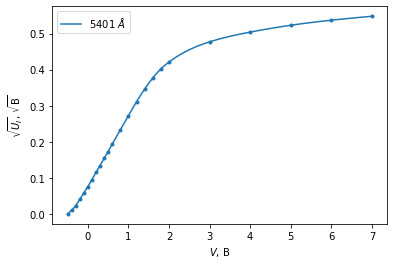

C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


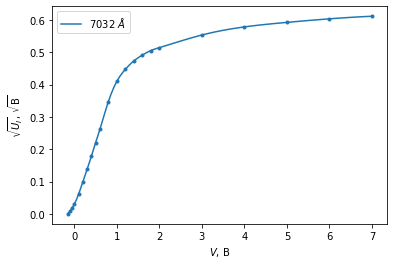

C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


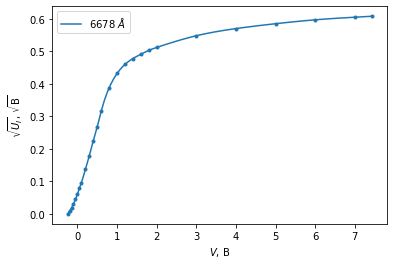

C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


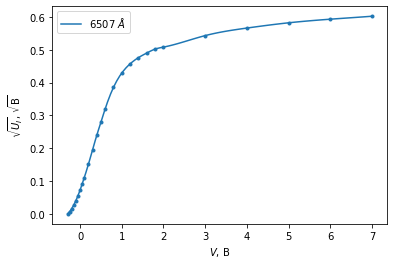

C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


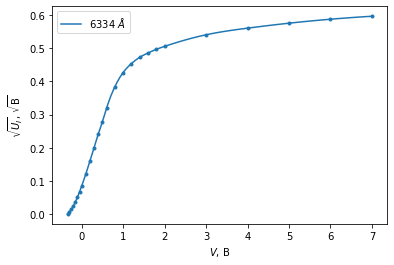

C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


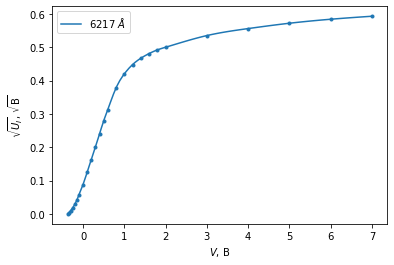

C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Quark\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


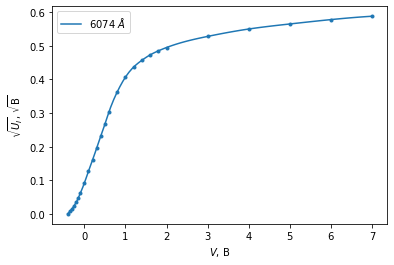

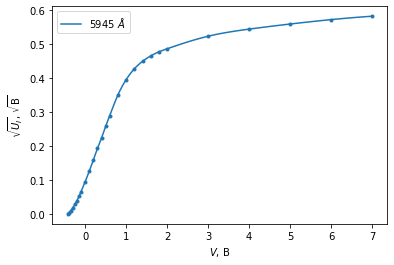

In [156]:

def interp(x, y):
    return sp.interpolate.interp1d(x, y, kind='cubic')

def process(cols, begin, end, begin_interp, end_interp, x_min):
    data = mipt.read_excel('data/5.1.1-stripped.xlsx', usecols=(cols), header=(0, 1))
    # Extract N from header
    m = re.compile(r"N=(\d+)")
    result = m.match(data.columns[0][0])
    assert result != None, "Wrong header syntax"
    N = int(result.group(1))

    # Remove top header
    data = data[f'N={N}']
    U_v = list(data['U_close'][begin:end])
    U_i = list(data['U_i'    ][begin:end])

    # Evaluate wavelen according to calibration
    wavelen = float(N2wavelen(N))
    
    U_v_clean, U_i_clean, equ = mipt.plot(U_v, U_i, begin=begin_interp, end=end_interp, x_min=x_min,
                                          label="{:.0f} $\AA$".format(wavelen), func=interp)
    
   
    plt.xlabel(r'$V$, В')
    plt.ylabel(r'$\sqrt{U_I}$, $\sqrt{\mathrm{В}}$')
    plt.legend()

    plt.savefig('gen/iv_full_{}.pdf'.format(N))
    plt.show()

process(('D', 'E'), 0, None, 0, None, None)
process(('G', 'H'), 0, None, 0, None, None)
process(('J', 'K'), 0, None, 0, None, None)
process(('M', 'N'), 0, None, 0, None, None)
process(('P', 'Q'), 0, None, 0, None, None)
process(('S', 'T'), 0, None, 0, None, None)
process(('V', 'W'), 0, None, 0, None, None)
process(('Y', 'Z'), 0, None, 0, None, None)

#plt.grid(True)

